<a href="https://colab.research.google.com/github/rland93/pendulum/blob/master/notebooks/PD_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf pendulum
!git clone https://github.com/rland93/pendulum.git

Cloning into 'pendulum'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (381/381), done.
remote: Compressing objects: 100% (280/280), done.
remote: Total 381 (delta 164), reused 282 (delta 93), pack-reused 0
Receiving objects: 100% (381/381), 6.75 MiB | 18.78 MiB/s, done.
Resolving deltas: 100% (164/164), done.


Import modules

In [2]:
import sys, os
sys.path.append('pendulum/')
print(sys.executable)
print(sys.version)

import numpy as np
import pandas as pd
from pendulum import controller, pendulum, sim, utils
from pendulum.viz import Visualizer
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

/usr/bin/python3
3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


Let's create the pendulum, simulation, and simulation parameters.

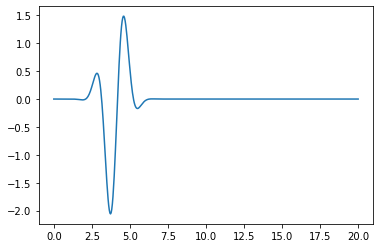

In [3]:
# simulation timings
dt = 0.01
t_final = 20
# pendulum 
pend = pendulum.Pendulum(1.0, 2.0, 3.0, initial_state=np.array([0,0,-0.05, 0]))
# forcing function
c1, c2, c3, c4, fshift = 4, 3, 1, 1, 4
force_fn = lambda t: c1 * np.sin(c2*t) * c3/(c4*np.sqrt(np.pi)) * np.exp(-((t-fshift)/c4)**2)
plt.plot(np.linspace(0,t_final, 500), force_fn(np.linspace(0,t_final, 500)))
# create simulation
simulation = sim.Simulation(dt, t_final, force_fn)

Now, we are going to create a PID controller from scratch. Let's start with a P controller, or proportional gain controller. In policy, we specify that the error is proportional to the input minus some reference value. In this case, we will set the policy based on a single input -- the value of $\theta$.

In [4]:
class PController(controller.Controller):
    def __init__(self, P):
        self.P = P
    def policy(self, state, t, dt, setpoint):
        # we control theta, which is stored in `state`
        theta = state[2]
        # our error is (reference - theta); so here, since our reference is 0, the error
        # is just equal to -theta
        error = -theta
        # finally, our action is proportional to this error
        action = self.P * error, {}
        return action

In [5]:
pcont = PController(100)
results1 = simulation.simulate(pend, pcont)

100%|██████████| 2000/2000 [00:00<00:00, 2123.23it/s]


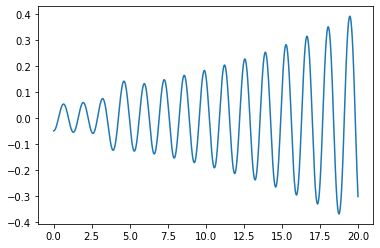

In [6]:
plt.plot(results1[('state', 't')])

We can see that our simple P-controller does not quite work. It does manage to handle the instability of the disturbance, as well as the instability of the starting condition, but it seems to display an oscillatory behavior; the controller can never quite catch up to the system dynamics. We can confirm our suspicion by extending the simulation time (try setting `t_final` to 60 or 120s to see). Maybe we can do better?

Perhaps we can use the derivative of the error to fix this instability. We introduce that below, by aproximating the derivative, and multiplying it by a gain, and then adding it into the P-controller.

In [7]:
class PDController(controller.Controller):
    def __init__(self, P, D):
        self.P = P
        self.D = D
        self.prior_error = 0
    def policy(self, state, t, dt, setpoint):
        # just as before, we create an action that is proportional to the error.
        theta = state[2]
        error = -theta
        Pterm = self.P * error
        # now, we add a derivative term. This involves calculating the derivative of the error 
        # with respect to time.
        deriv_error = (error - self.prior_error) / (2 * dt)
        Dterm = self.D * deriv_error
        # store the previous error so we can use it next time policy() is called...
        self.prior_error = error
        # add both terms
        action = Pterm + Dterm
        return action, {}

In [8]:
pdcont = PDController(100, 10)
results2 = simulation.simulate(pend, pdcont)

100%|██████████| 2000/2000 [00:00<00:00, 2227.10it/s]


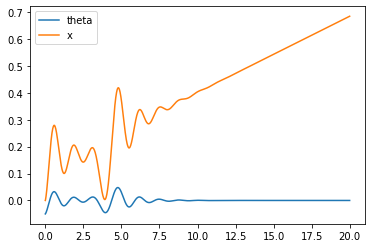

In [10]:
plt.plot(results2[('state', 't')], label='theta')
plt.plot(results2[('state', 'x')], label='x')
plt.legend()

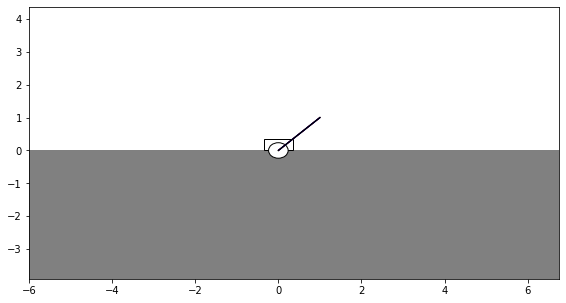

In [11]:
visualizer = Visualizer(results2, pend, speed=5)
anim = visualizer.animate((9.5, 5))

In [12]:
HTML(anim.to_html5_video())

Try experimenting with the simulator:

+ Change values of the pendulum. How do the system dynamics change when those parameters are changed?
+ Change values for the gains. How do different gains change the system response?
+ Try different starting conditions or forcing functions. Are there certain conditions for which the system is impossible or more challenging to stabilize?